In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import sys
import glob
from numba import autojit
from scipy.interpolate import interp1d
import matplotlib.gridspec as gridspec
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
import useful as hb
%matplotlib inline

In [2]:
# tau = ['3','10','30','100','300','1000','10000','Closed']
tau = ['3','300','3000','Closed']
Figletter = ['a) ', 'b) ', 'c) ', 'd) ', 'e) ',
             'f) ', 'g) ', 'h) ', 'i) ']
x = '/noc/msm/scratch/students/hb1g13/Mobilis'
# x = '/hpcdata/scratch/hb1g13/NchannelFlat'


# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()
# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r $^oC$ %'
else:
    fmt = '%r $^oC$'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'daynokpp/VTprimebar.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)


# Make Some useful functions
def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]


def regrid(Variable):
    Vc = (Variable[:, 0:-1]+Variable[:, 1::])/2
    return Vc
numba_regrid = autojit()(regrid)
numba_regrid.func_name = "numba_regrid"
Runs = np.array(runs)
# Set Parameters
alpha = 2.000000E-04
g = -9.81
rho_0 = 1000
C_p = 3985
gridfilepath = x+'/'+str(tau[0])+'daynokpp/'
file2 = netCDF4.Dataset(gridfilepath+'grid.nc', 'r')
Zp = file2.variables['Zp1'][:]
Z = file2.variables['Z'][:]
Y = file2.variables['Yp1'][:]
Yc = file2.variables['Y'][:]
Zmatrix = np.zeros((len(Z), len(Yc)))
Zmatrix[:, :] = 1
dx = Y[1]-Y[0]  # Find Resolution
dz = Zp[0:len(Zp)-1]-Zp[1:len(Zp)]
Zmatrix = np.apply_along_axis(np.multiply, 0, Zmatrix, dz)

In [3]:
def ddy_cgrid_centered(y):
    dy = np.zeros(y.shape, np.float) #we know it will be this size
    h = Y[1] - Y[0] #this assumes the points are evenely spaced!
    dy[:,2:-2] = (y[:,0:-4] - 8 * y[:,1:-3] + 8 * y[:,3:-1] - y[:,4:]) / (12.0 * h)

    # simple differences at the end-points
    dy[:,0] = (y[:,1] - y[:,0])/(Y[1] - Y[0])
    dy[:,1] = (y[:,2] - y[:,1])/(Y[2] - Y[1])
    dy[:,-2] = (y[:,-2] - y[:,-3]) / (Y[-2] - Y[-3])
    dy[:,-1] = (y[:,-1] - y[:,-2]) / (Y[-1] - Y[-2])
    return dy

def ddz_cgrid_centered(y):
    dy = np.zeros(y.shape, np.float) 
    dy[0] = (y[0] - y[1])/(Z[0] - Z[1])
    for i in range(1,len(y)-1):
        dy[i] = (y[i+1] - y[i-1])/(Z[i+1]-Z[i-1])
    dy[-1] = (y[-1] - y[-2])/(Z[-1] - Z[-2])
    return dy

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def get_psi_iso_z(PSISO, Th):
    """Put the output from psi_iso into Z coordinates."""

    psi_iso = PSISO
    # figure out the depth of each layer
    h = Th
    # psi_iso is defined at the *bottom* of each layer,
    # therefore we want the depth at the bottom of the layer
    z = cumsum(h, axis=0) - 2985
    # interpolate to center z points
    psi_iso_z = zeros((nz,ny))
    for j in arange(ny):
        psi_iso_z[:,j] = interp(Z[:],z[:,j], psi_iso[:,j])
    return psi_iso_z


In [3]:
filename = x+'/3daynokpp/VTprimebar.nc'
file2read = netCDF4.Dataset(filename,'r')
VT = VT=file2read.variables['VT'][:]
VTzoneorig = np.mean(VT,axis=2)

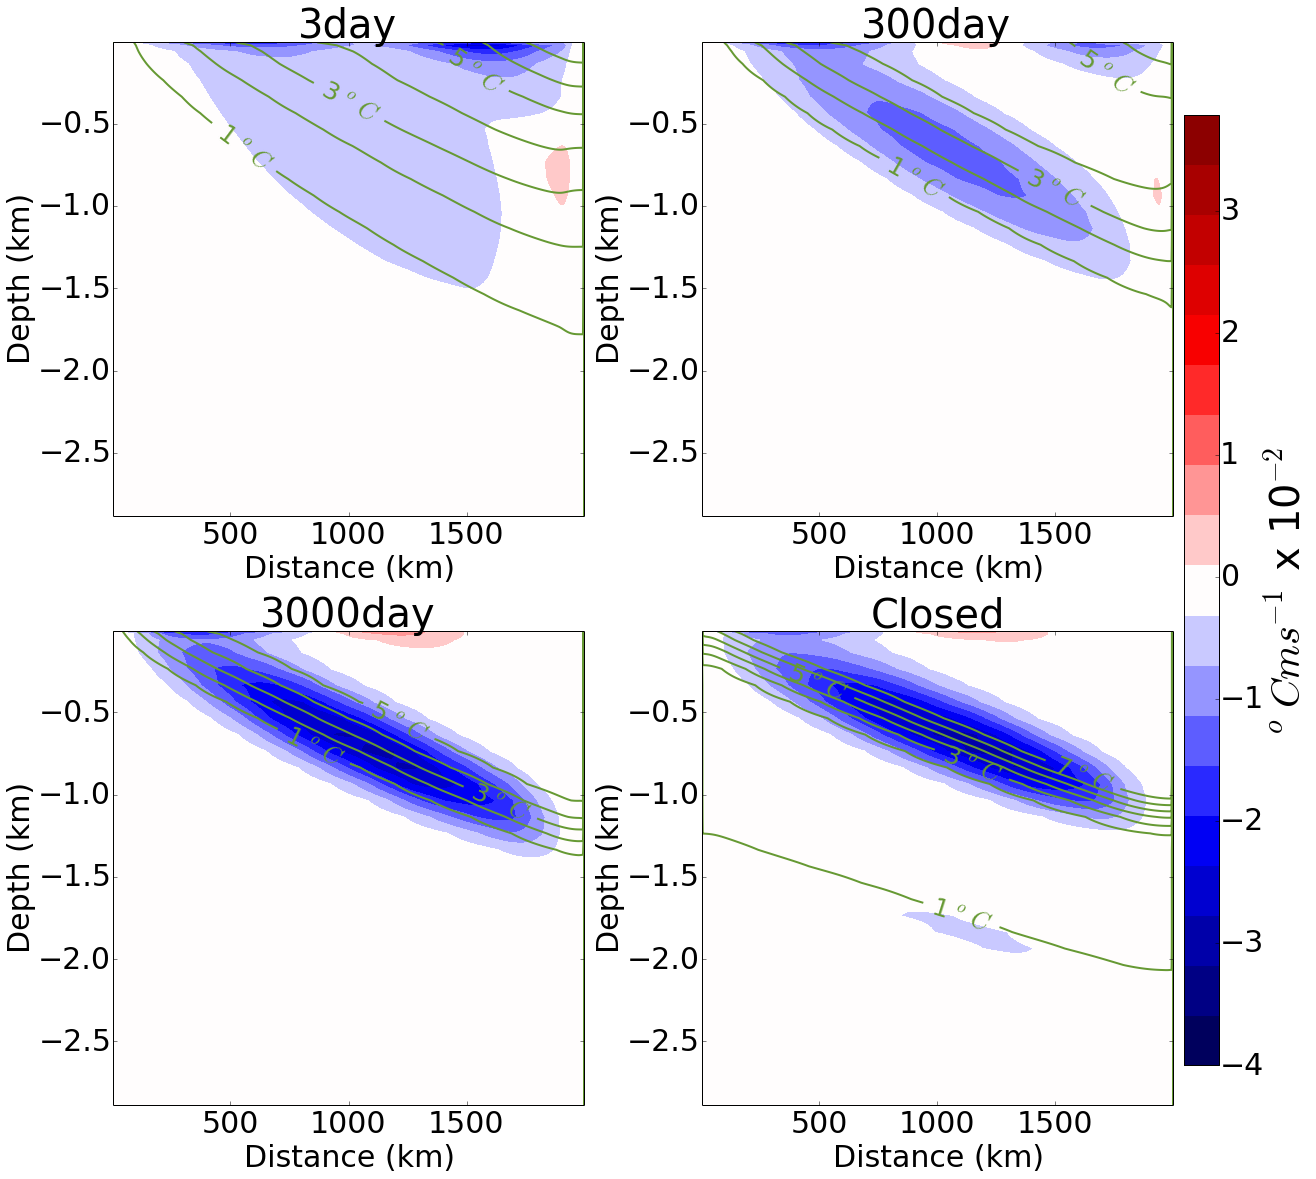

In [9]:
fig=plt.figure(figsize=(16.5,16.5))
for i in range(len(Runs)):
    fname=x+'/'+str(tau[Runs[i]])+'daynokpp/VTprimebar.nc'
    file2read = netCDF4.Dataset(fname,'r')
    VT=file2read.variables['VT']
    VTzone=np.mean(VT[:]*1,axis=2)
    VTdA=Zmatrix*VTzone
    filename=x+'/'+str(tau[Runs[i]])+'daynokpp/Tav.nc'
    file2read = netCDF4.Dataset(filename,'r')
    Temp=file2read.variables["THETA"] 
    Temp=Temp[:]
    Tzone=np.mean(np.mean(Temp,axis=0),axis = 2)
    Q2_levs = (np.arange(-1,8,1))
    y=Y/1000
    Q_levs = np.arange(-0.040,0.04,0.0041)
    Q_ticks = np.arange(-0.04,0.04,0.01)
    ax = fig.add_subplot(2, 2, i+1)
    VTzone[VTzone<-0.029]=-0.029
    p=ax.contourf(Yc/1000,Z/1000,VTzone*100,Q_levs*100,cmap=plt.cm.seismic) #Use b2r colourmap
    q=ax.contour(Yc/1000,Z/1000,Tzone,Q2_levs,colors='#669933',linewidths = 2)
    q.levels = [nf(val) for val in q.levels ]
    plt.clabel(q,q.levels[::2], inline=1,fmt=fmt, fontsize=25)
    #clim(-1,1) # Put 0 to white
    #cbar=plt.colorbar(cf, ticks=Psi_ticks, shrink=0.8)
    ax.set_title(str(tau[Runs[i]])+'day', fontsize=40)
    if str(tau[Runs[i]])=='Closed':
        ax.set_title(str(tau[Runs[i]]), fontsize=40)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
    #cbar=plt.colorbar(p, ticks=Psi_ticks, shrink=0.8)
    #ax.set_clim(-1,1)
    #cbar.ax.set_ylabel('$\psi \,\, (sv)$')
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar=fig.colorbar(p, cax=cax, ticks=Q_ticks*100)
cbar.ax.set_ylabel(r'$ ^o C m s^{-1}$ x 10$^{-2}$', fontsize=40)
cbar.ax.tick_params(labelsize=30)
q=( os.path.expanduser('~')+"/Figures/Mobilis")
if not os.path.exists(q):
       os.makedirs(q)
plt.savefig(q+"/VTpanel.png")

/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:32: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:33: RuntimeWarning: invalid value encountered in less
/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:34: RuntimeWarning: invalid value encountered in greater
/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:32: RuntimeWarning: divide by zero encountered in divide


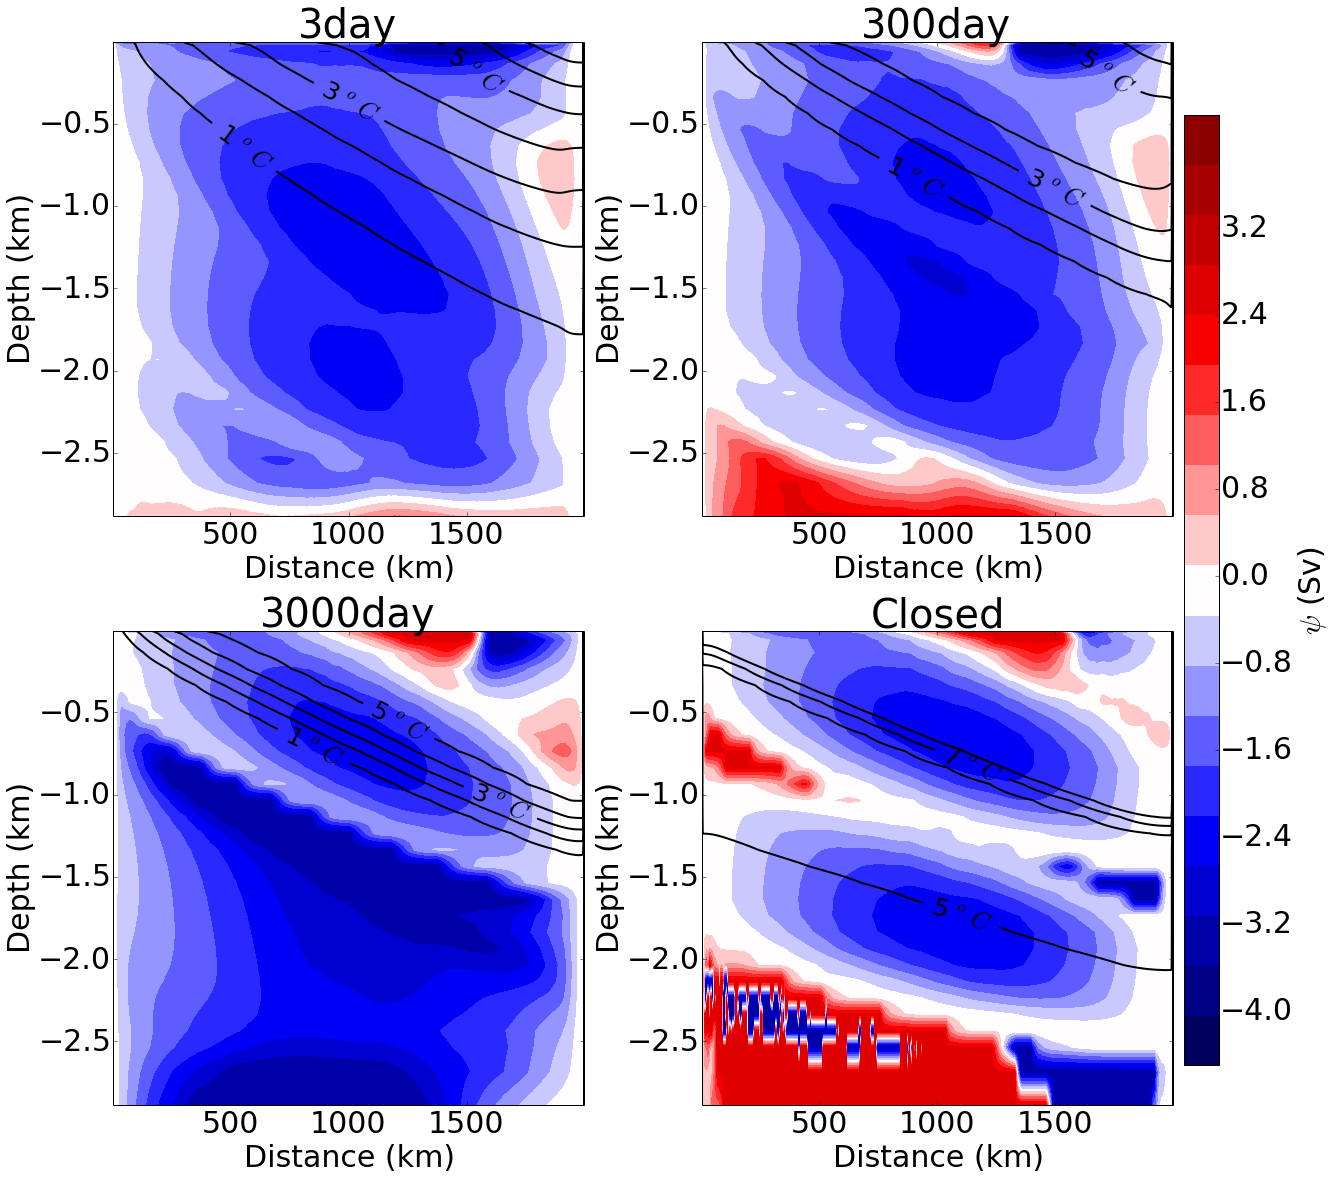

In [20]:
fig=plt.figure(figsize=(16.5,16.5))
for i in range(len(Runs)):
    fname=x+'/'+str(tau[Runs[i]])+'daynokpp/VTprimebar.nc'
    if not os.path.isfile(fname):
        continue
    file2read = netCDF4.Dataset(fname,'r')
    VT=file2read.variables['VT']
    VTzone=np.mean(VT[:]*1,axis=2)
    VTdA=VTzone/Zmatrix
    filename=x+'/'+str(tau[Runs[i]])+'daynokpp/Tav.nc'
    file2read = netCDF4.Dataset(filename,'r')
    Temp=file2read.variables["THETA"] 
    Tzone=np.mean(np.mean(Temp,axis=0),axis = 2)
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        Tavlat = np.apply_along_axis(np.subtract, 0, Tzone, tRef)
    else:
        Tzone=Tzone -4.0
    by = ddy_cgrid_centered(Tzone)
    bz = ddz_cgrid_centered(Tzone) 
    #bz[bz>-0.002/10]=-0.002/10
    Q2_levs = (np.arange(-1,8.1,1))
    y=Y/1000
    Q_levs = np.arange(-4.5,4.5,0.46)
    Q_ticks = np.arange(-4.0,4.0,0.8)
    ax = fig.add_subplot(2, 2, i+1)
    ED = VTdA/bz*Zmatrix*5000*10**-6*200 #Volume and sum channel in x
    ED[ED<-3.49]=-3.49
    ED[ED>2.49]=2.49
    if ED[17:-0,:]>0: ED*-1
    p=ax.contourf(Yc/1000,Z/1000,ED,Q_levs,cmap=plt.cm.seismic) #Use b2r colourmap
    q=ax.contour(Yc/1000,Z/1000,Tzone+4,Q2_levs,colors='k',linewidths = 2)
    q.levels = [nf(val) for val in q.levels ]
    plt.clabel(q,q.levels[::2], inline=1,fmt=fmt, fontsize=25)
    #clim(-1,1) # Put 0 to white
    #cbar=plt.colorbar(cf, ticks=Psi_ticks, shrink=0.8)
    ax.set_title(str(tau[Runs[i]])+'day', fontsize=40)
    if str(tau[Runs[i]])=='Closed':
        ax.set_title(str(tau[Runs[i]]), fontsize=40)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
    #cbar=plt.colorbar(p, ticks=Psi_ticks, shrink=0.8)
    #ax.set_clim(-1,1)
    #cbar.ax.set_ylabel('$\psi \,\, (sv)$')
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar=fig.colorbar(p, cax=cax, ticks=Q_ticks)
cbar.ax.set_ylabel(r'$ \psi $ (Sv)', fontsize=30)
cbar.ax.tick_params(labelsize=30)
q=( os.path.expanduser('~')+"/Figures/Mobilis")
if not os.path.exists(q):
       os.makedirs(q)
plt.savefig(q+"/VTpanel.png")

/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:43: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:44: RuntimeWarning: invalid value encountered in less
/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:45: RuntimeWarning: invalid value encountered in greater
/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:23: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:43: RuntimeWarning: divide by zero encountered in divide


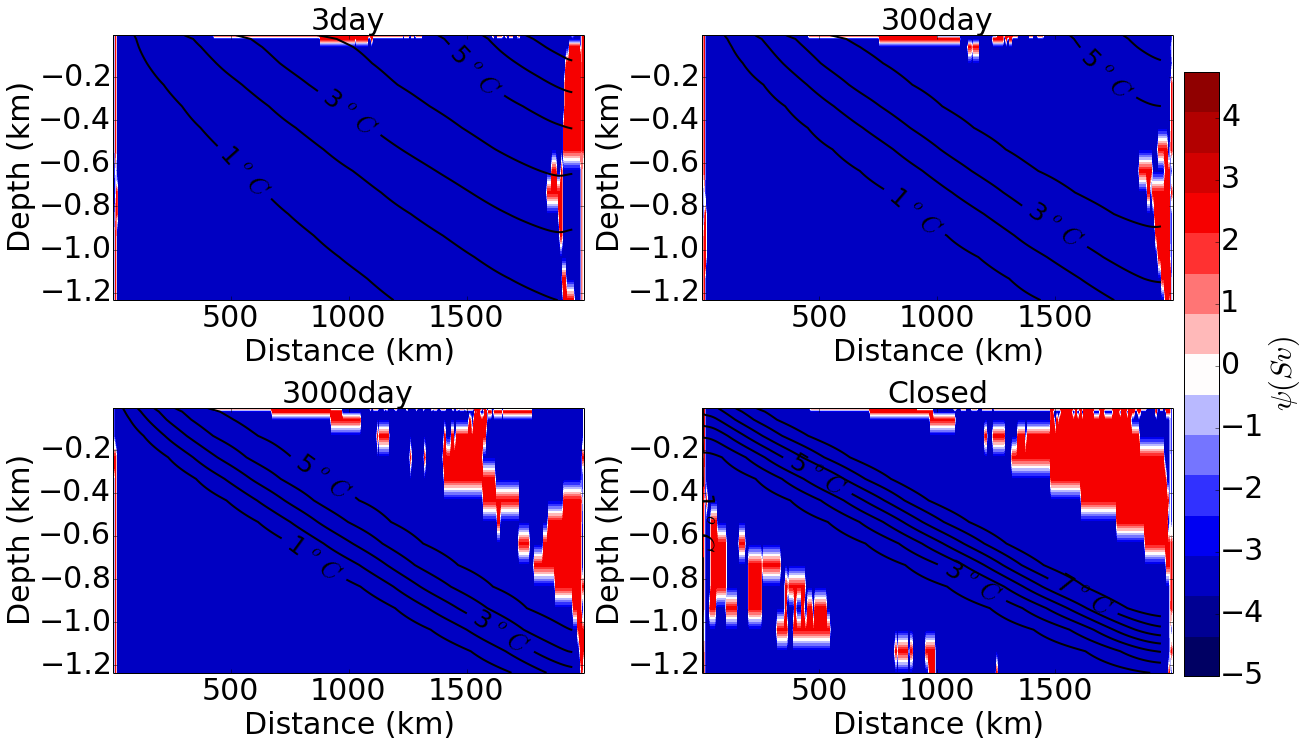

In [10]:
fig=plt.figure(figsize=(16.5,10.5))
for i in range(len(Runs)):
    fname=x+'/'+str(tau[Runs[i]])+'daynokpp/WTprimebar.nc'
    if not os.path.isfile(fname):
        continue
    file2read = netCDF4.Dataset(fname,'r')
    VT=file2read.variables['WT']
    VTzone=np.mean(VT[:]*1,axis=2)
    VTdA=VTzone
    filename=x+'/'+str(tau[Runs[i]])+'daynokpp/Tav.nc'
    file2read = netCDF4.Dataset(filename,'r')
    Temp=file2read.variables["THETA"] 
    Temp=Temp[:]
    Tzone=np.mean(np.mean(Temp,axis=0),axis = 2)
    #Interpolate
    by = ddy_cgrid_centered(Tzone)
    bz = ddz_cgrid_centered(Tzone)
    by = by/5000
    Q2_levs = (np.arange(0.1,8.1,1))
    y=Y/1000
    Q_levs = np.arange(-3.55,3.55,0.42)
    Q_ticks = np.arange(-5,1.0,0.6)
    ED1=-VTzone/by*5000*10**-6*200
    ED1[ED1<-3.49]=-3.49
    ED1[ED1>2.49]=2.49
    fname=x+'/'+str(tau[Runs[i]])+'daynokpp/VTprimebar.nc'
    if not os.path.isfile(fname):
        continue
    file2read = netCDF4.Dataset(fname,'r')
    VT=file2read.variables['VT']
    VTzone=np.mean(VT[:]*1,axis=2)
    VTdA=VTzone/Zmatrix
    filename=x+'/'+str(tau[Runs[i]])+'daynokpp/Tav.nc'
    file2read = netCDF4.Dataset(filename,'r')
    Temp=file2read.variables["THETA"] 
    Temp=Temp[:]
    Tzone=np.mean(np.mean(Temp,axis=0),axis = 2)
    Q2_levs = (np.arange(-1.,8.1,1))
    y=Y/1000
    Q_levs = np.arange(-5.01,5.01,0.65)
    Q_ticks = np.arange(-5.0,5.0,1.)
    ax = fig.add_subplot(2, 2, i+1)
    ED=-VTdA/bz*Zmatrix*5000*10**-6*200 #Volume and sum channel in x
    ED[ED<-3.49]=-3.49
    ED[ED>2.49]=2.49
    ax = fig.add_subplot(2, 2, i+1)
    p=ax.contourf(Yc/1000,Z[0:15]/1000,ED1[0:15],Q_levs,cmap=plt.cm.seismic) #Use b2r colourmap
    q=ax.contour(Yc[0:-10]/1000,Z[0:15]/1000,Tzone[0:15,0:-10],Q2_levs,colors='k',linewidths = 2)
    q.levels = [nf(val) for val in q.levels ]
    plt.clabel(q,q.levels[::2], inline=1,fmt=fmt, fontsize=25)
    #clim(-1,1) # Put 0 to white
    #cbar=plt.colorbar(cf, ticks=Psi_ticks, shrink=0.8)
    ax.set_title(str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]])=='Closed':
        ax.set_title(str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
    #cbar=plt.colorbar(p, ticks=Psi_ticks, shrink=0.8)
    #ax.set_clim(-1,1)
    #cbar.ax.set_ylabel('$\psi \,\, (sv)$')
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar=fig.colorbar(p, cax=cax, ticks=Q_ticks )
cbar.ax.set_ylabel(r'$ \psi (Sv)$', fontsize=30)
cbar.ax.tick_params(labelsize=30)
q=( os.path.expanduser('~')+"/Figures/Mobilis")
if not os.path.exists(q):
       os.makedirs(q)
plt.savefig(q+"/VTpanel.png")

/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:24: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:24: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:28: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:24: RuntimeWarning: invalid value encountered in add


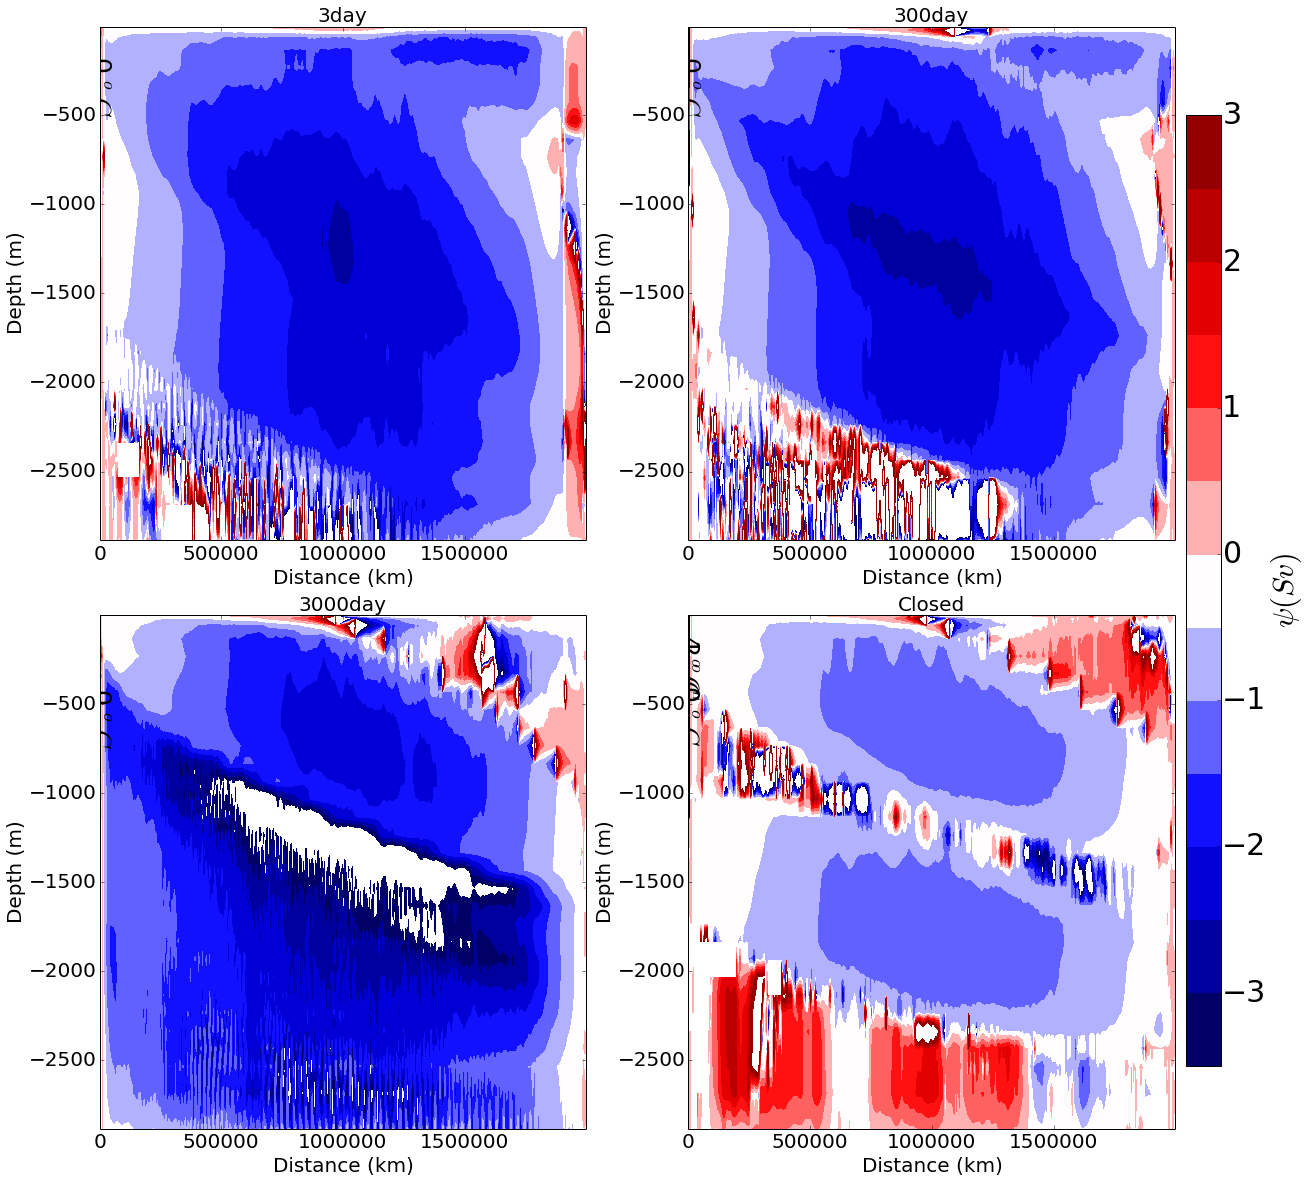

In [13]:
fig=plt.figure(figsize=(16.5,16.5))
for i in range(len(Runs)):
    fname=x+'/'+str(tau[Runs[i]])+'daynokpp/WTprimebar.nc'
    fname2=x+'/'+str(tau[Runs[i]])+'daynokpp/VTprimebar.nc'
    if not os.path.isfile(fname):
        continue
    file2read = netCDF4.Dataset(fname,'r')
    WT=file2read.variables['WT']
    WTzone=np.mean(WT[:]*1,axis=2)
    file2read = netCDF4.Dataset(fname2,'r')
    VT=file2read.variables['VT']
    VTzone=np.mean(VT[:]*1,axis=2)
    filename=x+'/'+str(tau[Runs[i]])+'daynokpp/Tav.nc'
    file2read = netCDF4.Dataset(filename,'r')
    Temp=file2read.variables["THETA"] 
    Temp=Temp[:]-4.0
    Tzone=np.mean(np.mean(Temp,axis=0),axis = 2)
    #Interpolate
    by = ddy_cgrid_centered(Tzone)
    bz = ddz_cgrid_centered(Tzone)
    VTzone[VTzone[10::]>0.001]=0.001
    Q2_levs = (np.arange(0,8,1))
    y=Y/1000
    Edav=(VTzone/bz+WTzone/by)/2
    Q_levs = np.arange(-3.5,3.5,0.5)
    Q_ticks = np.arange(-5,1.0,0.6)
    ax = fig.add_subplot(2, 2, i+1)
    p=ax.contourf(Yc,Z,-WTzone/by,Q_levs,cmap=plt.cm.seismic) #Use b2r colourmap
    q=ax.contour(Yc/1000,Z,Tzone,Q2_levs,colors='k',linewidths = 2)
    q.levels = [nf(val) for val in q.levels ]
    plt.clabel(q,q.levels[::2], inline=1,fmt=fmt, fontsize=25)
    #clim(-1,1) # Put 0 to white
    #cbar=plt.colorbar(cf, ticks=Psi_ticks, shrink=0.8)
    ax.set_title(str(tau[Runs[i]])+'day', fontsize=20)
    if str(tau[Runs[i]])=='Closed':
        ax.set_title(str(tau[Runs[i]]), fontsize=20)
    ax.set_xlabel('Distance (km)', fontsize=20)
    ax.set_ylabel('Depth (m)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    #cbar=plt.colorbar(p, ticks=Psi_ticks, shrink=0.8)
    #ax.set_clim(-1,1)
    #cbar.ax.set_ylabel('$\psi \,\, (sv)$')
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar=fig.colorbar(p, cax=cax)
cbar.ax.set_ylabel(r'$ \psi (Sv)$', fontsize=30)
cbar.ax.tick_params(labelsize=30)
q=( os.path.expanduser('~')+"/Figures/Mobilis")
if not os.path.exists(q):
       os.makedirs(q)
plt.savefig(q+"/VTpanel.png")

/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:21: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:27: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:27: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:21: RuntimeWarning: invalid value encountered in divide


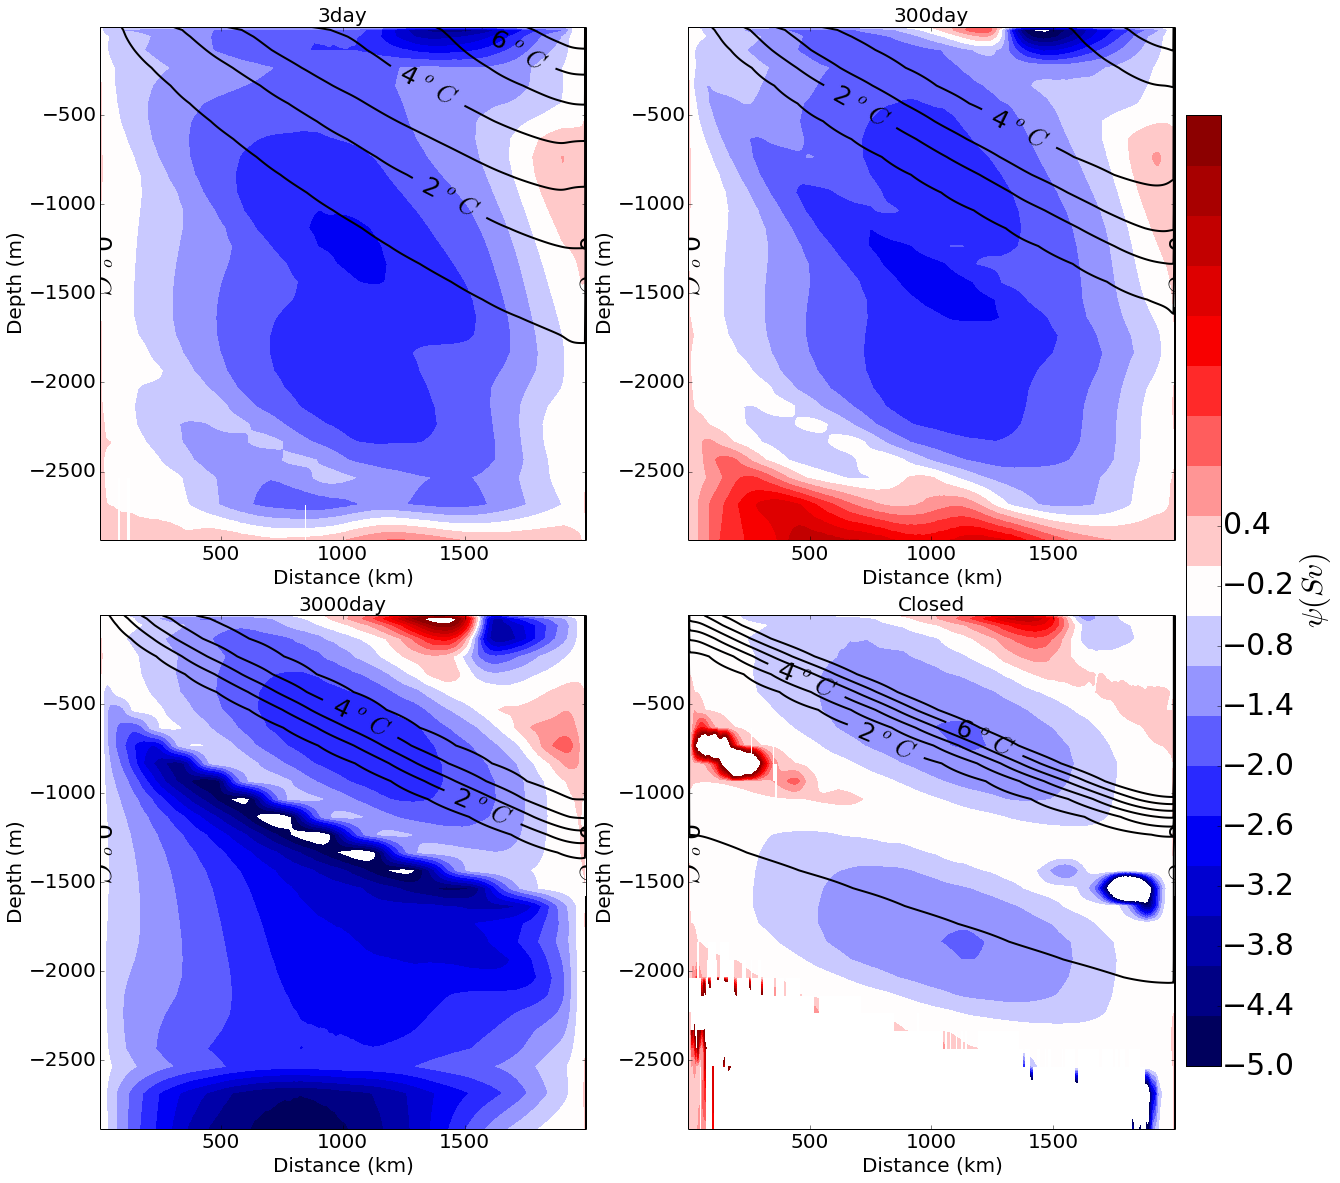

In [8]:
fig=plt.figure(figsize=(16.5,16.5))
for i in range(len(Runs)):
    fname=x+'/'+str(tau[Runs[i]])+'daynokpp/VTprimebar.nc'
    if not os.path.isfile(fname):
        continue
    file2read = netCDF4.Dataset(fname,'r')
    VT=file2read.variables['VT']
    VTzone=np.mean(VT[:]*1,axis=2)
    VTdA=VTzone
    filename=x+'/'+str(tau[Runs[i]])+'daynokpp/Tav.nc'
    file2read = netCDF4.Dataset(filename,'r')
    Temp=file2read.variables["THETA"] 
    Temp=Temp[:]
    Tzone=np.mean(np.mean(Temp,axis=0),axis = 2)
    bz, by = np.gradient(Tzone)
    by = by/5000
    bz = bz / Zmatrix
    s = np.mean(by[3:-10,100:-100]/bz[3:-10,100:-100])
    S=by/bz
    Q2_levs = (np.arange(0,8,1))
    y=Y/1000
    Q_levs = np.arange(-5.0,5.0,0.5)
    Q_ticks = np.arange(-5,1.0,0.6)
    ax = fig.add_subplot(2, 2, i+1)
    p=ax.contourf(Yc/1000,Z/1000,-VTdA*S/by,Q_levs,cmap=plt.cm.seismic) #Use b2r colourmap
    q=ax.contour(Yc/1000,Z/1000,Tzone,Q2_levs,colors='k',linewidths = 2)
    q.levels = [nf(val) for val in q.levels ]
    plt.clabel(q,q.levels[::2], inline=1,fmt=fmt, fontsize=25)
    ax.set_title(str(tau[Runs[i]])+'day', fontsize=20)
    if str(tau[Runs[i]])=='Closed':
        ax.set_title(str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar=fig.colorbar(p, cax=cax, ticks=Q_ticks)
cbar.ax.set_ylabel(r'$ \psi (Sv)$', fontsize=30)
cbar.ax.tick_params(labelsize=30)
q=( os.path.expanduser('~')+"/Figures/Mobilis")
if not os.path.exists(q):
       os.makedirs(q)
plt.savefig(q+"/VTpanel.png")